### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar10 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 1

In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [4]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [5]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [6]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [7]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [8]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [ ]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=24)
            if i == 0: axes[i].legend(prop={"size": 16}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 10)))

    fig.supxlabel("Task Trained On", fontsize=24)
    fig.supylabel("Accuracy (%)\n", fontsize=24)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

# ER

## Buffer 500

### Accuracy Without Drift

In [10]:
# er_500_accuracy_array_without_drift = read_results(
#     "./logs/01-18-25-05-28-50-seq-cifar10-er-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 33.82, 33.86, 34.32, 34.74, 35.13
# # 34.374 ± 0.5058695484015628
# plot_results(
#     er_500_accuracy_array_without_drift,
#     title="ER Baseline (buf=500)",
# )
# average_forgetting(er_500_accuracy_array_without_drift)[1]

In [11]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-18-25-05-28-50-seq-cifar10-er-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-18-25-05-28-50-seq-cifar10-er-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 34.32 ± 0.00
Avg. Forgetting: 74.96 ± 0.00


### Permutation Drift in Task 3

In [12]:
# er_500_accuracy_array_with_drift = read_results(
#     "./logs/01-18-25-23-02-01-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-0.json"
# )
# # 31.76, 31.96, 32.28, 32.61, 33.21
# # 32.364000000000004 ± 0.5121171740920233
# plot_results(
#     er_500_accuracy_array_with_drift,
#     title="ER with Permutation Drift in Task 3 (buf=500)",
# )
# average_forgetting(er_500_accuracy_array_with_drift)[1]

In [13]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-18-25-23-02-01-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-0.json"
)

1 files found
1: ./logs/01-18-25-23-02-01-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-0.json
FAA: 32.28 ± 0.00
Avg. Forgetting: 77.06 ± 0.00


### Permutation Drift in Task 3 with Full Relearning

In [14]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-19-25-01-28-12-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-1.json"
# ) # 55.94, 56.16, 56.35, 56.95, 57.22
# # 56.524 ± 0.48367757855828

In [15]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-01-33-47-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 55.22, 55.88, 56.90
# plot_results(
#     er_500_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Task 3 and Full Relearning (buf=500)",
# )

In [16]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-01-33-47-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-00-53-43-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-00-14-49-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 56.00 ± 0.69
Avg. Forgetting: 47.00 ± 0.62


### Permutation Drift in Task 3 with Buffer Resampling

In [17]:
## before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-19-25-03-00-55-seq-cifar10-er-buf-500-drift-5-n-1-adaptation-2.json"
# ) # 49.08, 50.00, 50.21, 50.72, 51.84
# # 50.37 ± 0.9066421565314524

In [18]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )

# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-02-02-32-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 51.18, 52.06, 52.41
# plot_results(
#     er_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
# )

In [19]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-02-31-31-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-02-58-33-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-02-02-32-seq-cifar10-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 51.88 ± 0.52
Avg. Forgetting: 52.44 ± 0.71


### Cumulative Plots

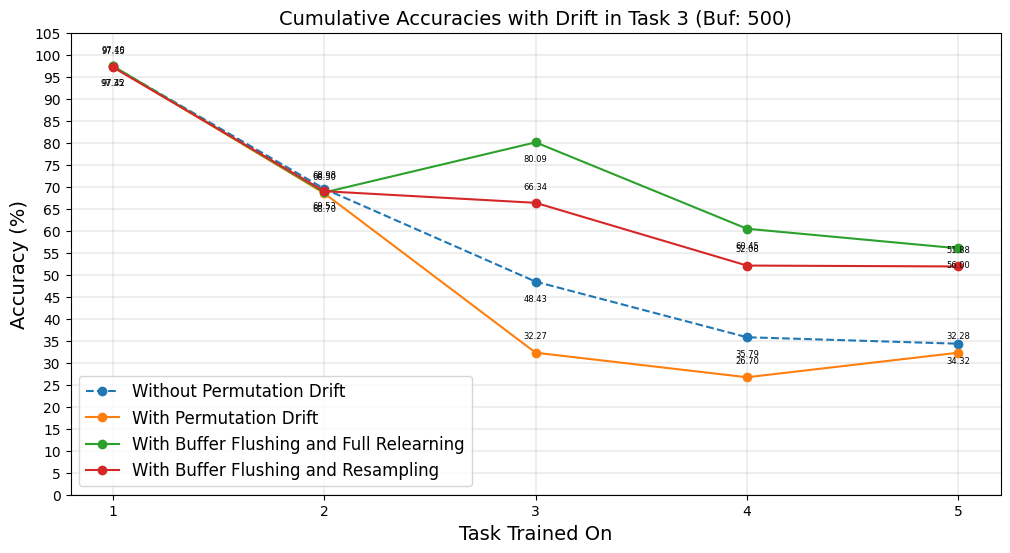

In [20]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [21]:
# er_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-07-25-03-16-59-seq-cifar10-er-buf-5000-no-drift.json"
# )
# # 65.46, 65.59, 66.41, 66.56, 66.81
# # 66.166 ± 0.5403184246349569
# plot_results(
#     er_5000_accuracy_array_without_drift,
#     title="ER Baseline (buf=5000)",
# )
# average_forgetting(er_5000_accuracy_array_without_drift)[1]

In [22]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-07-25-03-16-59-seq-cifar10-er-buf-5000-no-drift.json"
)

1 files found
1: ./logs/01-07-25-03-16-59-seq-cifar10-er-buf-5000-no-drift.json
FAA: 66.41 ± 0.00
Avg. Forgetting: 33.25 ± 0.00


### Permutation Drift in Task 3

In [23]:
# er_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-07-25-07-56-20-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 47.27, 47.33, 47.61, 47.77, 47.82
# # 47.559999999999995 ± 0.22414281161795058
# plot_results(
#     er_5000_accuracy_array_with_drift,
#     title="ER with Permutation Drift in Task 3 (buf=5000)",
# )
# average_forgetting(er_5000_accuracy_array_with_drift)[1]

In [24]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-07-25-07-56-20-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-07-25-07-56-20-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 47.61 ± 0.00
Avg. Forgetting: 56.36 ± 0.00


### Permutation Drift in Task 3 with Full Relearning

In [25]:
## before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-07-25-09-28-31-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
# ) # 74.5, 74.6, 75.15, 75.7, 75.81
# # 75.152 ± 0.5409399227271015

In [26]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-00-51-54-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 74.87, 75.11, 75.83
# plot_results(
#     er_5000_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
# )

In [27]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-00-16-17-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-01-32-14-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-00-51-54-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 75.27 ± 0.41
Avg. Forgetting: 21.78 ± 0.35


### Permutation Drift in Task 3 with Buffer Resampling

In [28]:
## before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-07-25-10-19-11-seq-cifar10-er-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
# ) # 74.19, 74.29, 74.33, 74.69, 75.01
# # 74.502 ± 0.3050508154390031

In [29]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-02-57-39-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 73.33, 74.15, 74.20, 74.24, 74.43
# plot_results(
#     er_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
# )

In [30]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-02-28-34-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-02-00-44-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-02-57-39-seq-cifar10-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 73.92 ± 0.42
Avg. Forgetting: 24.33 ± 0.43


### Cumulative Plots

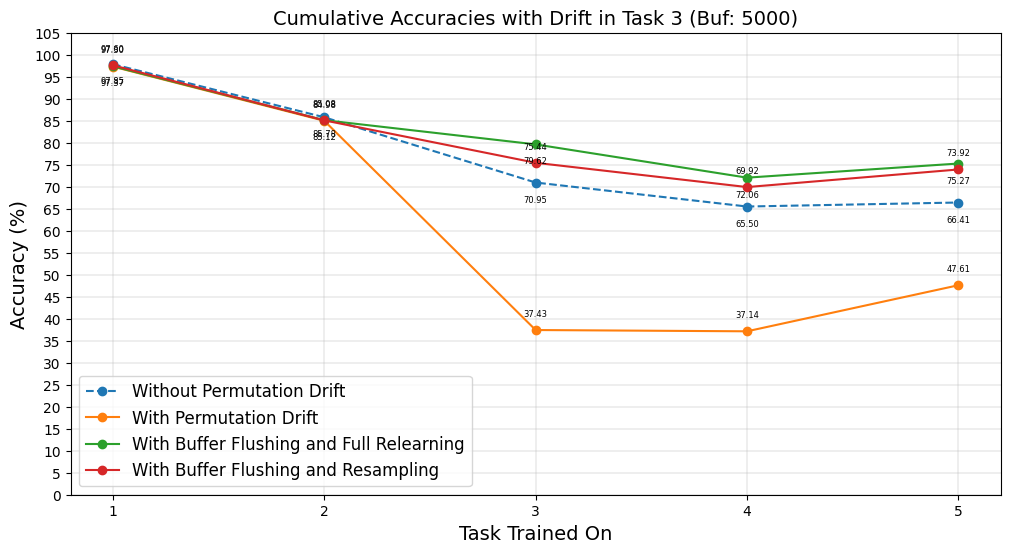

In [31]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

In [32]:
# er_ace_500_accuracy_array_without_drift = read_results(
#     "./logs/01-18-25-05-28-50-seq-cifar10-er_ace-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 55.74, 56.39, 57.73, 57.98, 58.76
# # 57.31999999999999 ± 1.0989631476987733
# plot_results(
#     er_ace_500_accuracy_array_without_drift,
#     title="ER-ACE Baseline (buf=500)",
# )
# average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

In [33]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-18-25-05-28-50-seq-cifar10-er_ace-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-18-25-05-28-50-seq-cifar10-er_ace-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 57.73 ± 0.00
Avg. Forgetting: 29.26 ± 0.00


### Permutation Drift in Task 3

In [34]:
# er_ace_500_accuracy_array_with_drift = read_results(
#     "./logs/01-18-25-22-56-03-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-0.json"
# )
# # 36.25, 37.02, 37.92, 38.44, 38.77
# # 37.68 ± 0.927771523598348
# plot_results(
#     er_ace_500_accuracy_array_with_drift,
#     title="ER-ACE with Permutation Drift in Task 3 (buf=500)",
# )
# average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

In [35]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-18-25-22-56-03-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-0.json"
)

1 files found
1: ./logs/01-18-25-22-56-03-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-0.json
FAA: 37.92 ± 0.00
Avg. Forgetting: 52.40 ± 0.00


### Permutation Drift in Task 3 with Full Relearning

In [36]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-19-25-01-21-29-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-1.json"
# ) # 62.72, 63.26, 63.47, 64.02
# # 63.36749999999999 ± 0.4655843103026552

In [37]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )

# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-00-40-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 59.95, 59.97, 61.57
# plot_results(
#     er_ace_500_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Task 3 and Full Relearning (buf=500)",
# )

In [38]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-02-48-55-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-00-40-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-01-42-19-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 60.50 ± 0.76
Avg. Forgetting: 27.72 ± 1.21


### Permutation Drift in Task 3 with Buffer Resampling

In [39]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-19-25-18-34-18-seq-cifar10-er_ace-buf-500-drift-5-n-1-adaptation-2.json"
# ) # 59.62, 59.76, 60.38, 61.15, 61.57
# # 60.496 ± 0.762065613972971

In [40]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )

# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-03-36-20-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 59.47, 59.62, 60.96
# plot_results(
#     er_ace_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
# )

In [41]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-03-36-20-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-05-15-07-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-04-24-38-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 60.02 ± 0.67
Avg. Forgetting: 31.63 ± 0.77


### Cumulative Plots

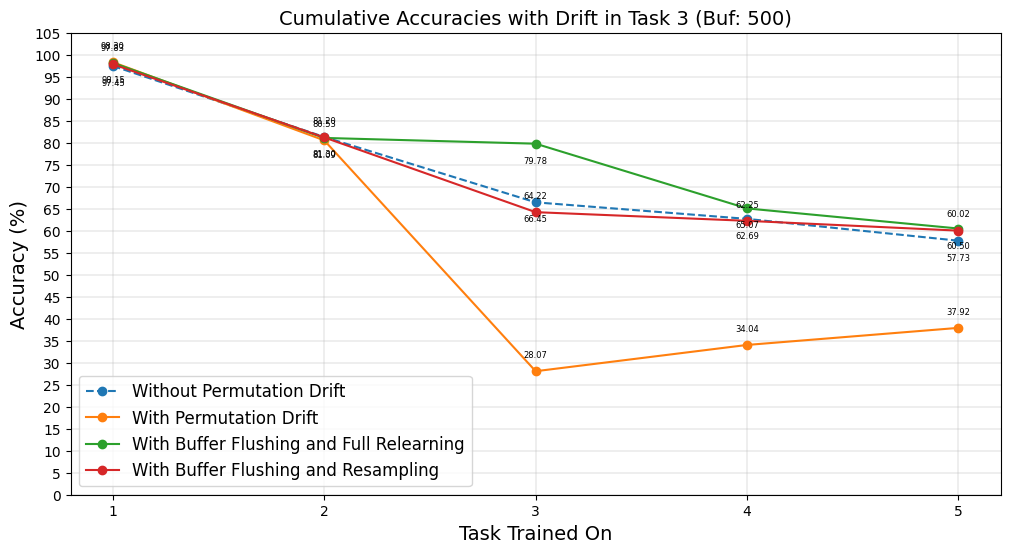

In [42]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [43]:
# er_ace_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-14-25-23-00-53-seq-cifar10-er_ace-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 68.05, 68.51, 68.72, 68.74, 69.78
# # 68.75999999999999 ± 0.5672741841473141
# plot_results(
#     er_ace_5000_accuracy_array_without_drift,
#     title="ER-ACE Baseline (buf=5000)",
# )
# average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

In [44]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-14-25-23-00-53-seq-cifar10-er_ace-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-14-25-23-00-53-seq-cifar10-er_ace-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 68.72 ± 0.00
Avg. Forgetting: 13.86 ± 0.00


### Permutation Drift in Task 3

In [45]:
# er_ace_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-14-25-23-01-52-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 44.06, 44.22, 44.64, 44.90, 45.27
# # 44.61800000000001 ± 0.4415608678313787
# plot_results(
#     er_ace_5000_accuracy_array_with_drift,
#     title="ER-ACE with Permutation Drift in Task 3 (buf=5000)",
# )
# average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

In [46]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-14-25-23-01-52-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-14-25-23-01-52-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 44.64 ± 0.00
Avg. Forgetting: 46.05 ± 0.00


### Permutation Drift in Task 3 with Full Relearning

In [47]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-14-25-23-33-58-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
# ) # 73.64, 73.84, 73.92, 74.19, 74.39
# # 73.99600000000001 ± 0.26446927987953456

In [48]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-01-47-26-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 70.59, 70.96, 71.67
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
# )

In [49]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-01-47-26-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-02-51-35-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-00-44-27-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 71.07 ± 0.45
Avg. Forgetting: 15.28 ± 0.31


### Permutation Drift in Task 3 with Buffer Resampling

In [50]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-14-25-23-10-23-seq-cifar10-er_ace-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
# ) # 72.52, 73.1, 73.23, 73.26, 73.28
# # 73.078 ± 0.28596503282744473

In [51]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-04-29-39-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 73.16, 73.64, 73.94
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
# )

In [52]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-05-20-00-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-03-39-50-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-04-29-39-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 73.58 ± 0.32
Avg. Forgetting: 15.72 ± 0.41


### Cumulative Plots

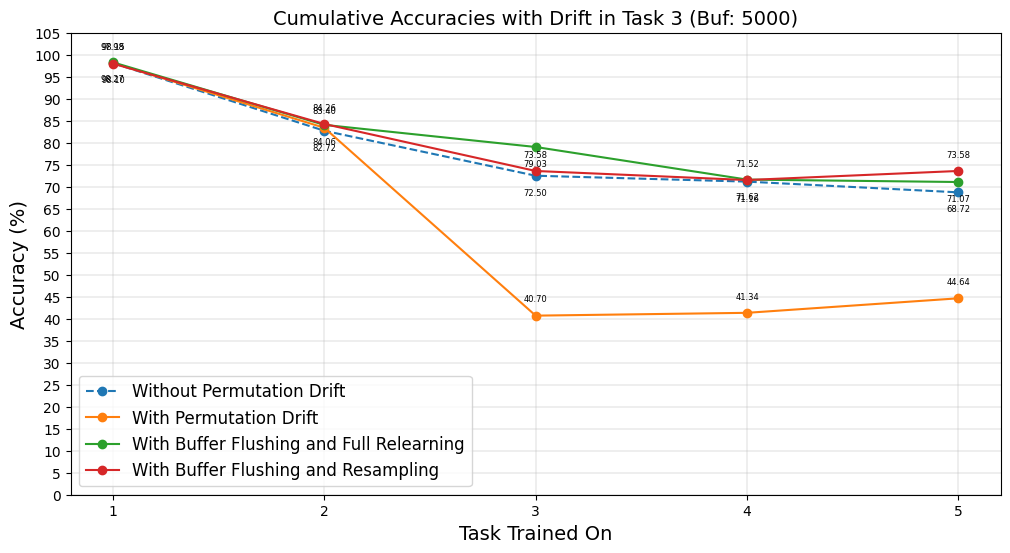

In [53]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Accuracy Without Drift

In [54]:
# derpp_500_accuracy_array_without_drift = read_results(
#     "./logs/01-18-25-19-53-51-seq-cifar10-derpp-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 40.35, 41.20, 41.61, 41.63, 42.23
# # 41.404 ± 0.6210185182424098
# plot_results(
#     derpp_500_accuracy_array_without_drift,
#     title="DER++ Baseline (buf=500)",
# )
# average_forgetting(derpp_500_accuracy_array_without_drift)[1]

In [55]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-18-25-19-53-51-seq-cifar10-derpp-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-18-25-19-53-51-seq-cifar10-derpp-buf-500-drift-6-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 41.61 ± 0.00
Avg. Forgetting: 63.55 ± 0.00


### Permutation Drift in Task 3

In [56]:
# derpp_500_accuracy_array_with_drift = read_results(
#     "./logs/01-19-25-01-40-51-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-0.json"
# )
# # 35.85, 37.12, 38.15, 38.60, 39.44
# # 37.832 ± 1.241924313313818
# plot_results(
#     derpp_500_accuracy_array_with_drift,
#     title="DER++ with Permutation Drift in Task 3 (buf=500)",
# )
# average_forgetting(derpp_500_accuracy_array_with_drift)[1]

In [57]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-19-25-01-40-51-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-0.json"
)

1 files found
1: ./logs/01-19-25-01-40-51-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-0.json
FAA: 38.15 ± 0.00
Avg. Forgetting: 68.14 ± 0.00


### Permutation Drift in Task 3 with Full Relearning

In [58]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-19-25-20-10-13-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-1.json"
# ) # 59.94, 61.09, 61.97, 62.82, 63.87
# # 61.938 ± 1.3581369592202395

In [59]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-05-04-57-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 63.32, 63.55, 66.05
# plot_results(
#     derpp_500_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Task 3 and Full Relearning (buf=500)",
# )

In [60]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-01-28-57-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-05-04-57-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-03-15-39-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 64.31 ± 1.24
Avg. Forgetting: 35.21 ± 1.64


### Permutation Drift in Task 3 with Buffer Resampling

In [61]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-20-25-04-17-47-seq-cifar10-derpp-buf-500-drift-5-n-1-adaptation-2.json"
# ) # 50.92, 55.55, 55.69, 55.73, 56.73
# # 54.924 ± 2.045576691302478

In [62]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-07-43-59-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 52.87, 56.14, 56.38
# plot_results(
#     derpp_500_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
# )

In [63]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-06-23-34-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-09-03-29-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-07-43-59-seq-cifar10-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 55.13 ± 1.60
Avg. Forgetting: 46.51 ± 2.07


### Cumulative Plots

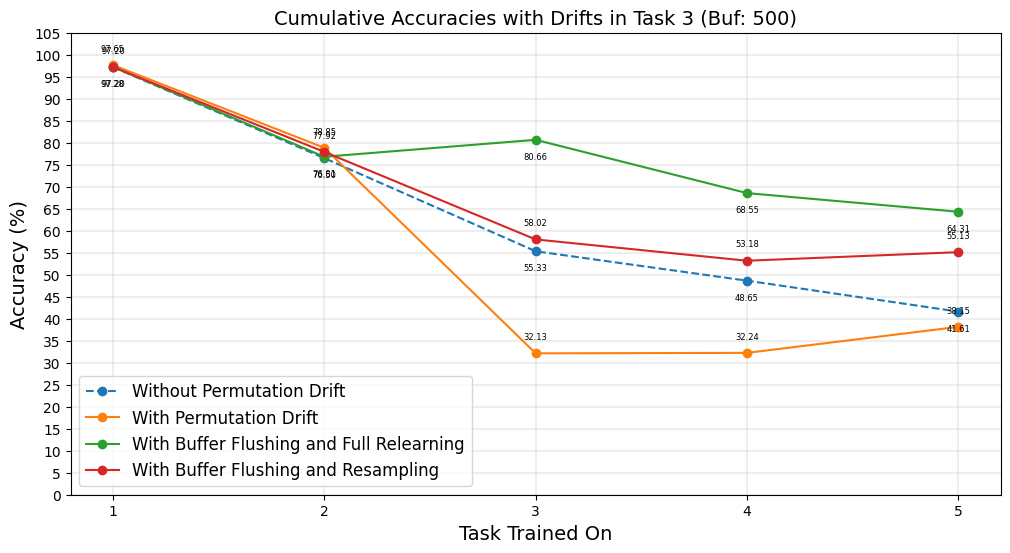

In [64]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [65]:
# derpp_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-15-25-02-01-27-seq-cifar10-derpp-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 63.82, 64.41, 65.27, 66.30, 66.07
# # 65.174 ± 0.9483585819720287
# plot_results(
#     derpp_5000_accuracy_array_without_drift,
#     title="DER++ Baseline (buf=5000)",
# )
# average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

In [66]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-15-25-02-01-27-seq-cifar10-derpp-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-15-25-02-01-27-seq-cifar10-derpp-buf-5000-drift-6-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 65.27 ± 0.00
Avg. Forgetting: 29.63 ± 0.00


### Permutation Drift in Task 3

In [67]:
# derpp_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-15-25-02-11-26-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
# )
# # 46.12, 46.27, 46.76, 46.81, 46.96
# # 46.584 ± 0.32781702213277497
# plot_results(
#     derpp_5000_accuracy_array_with_drift,
#     title="DER++ with Permutation Drift in Task 3 (buf=5000)",
# )
# average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

In [68]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-15-25-02-11-26-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-15-25-02-11-26-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-0-cpd-0.json
FAA: 46.76 ± 0.00
Avg. Forgetting: 52.06 ± 0.00


### Permutation Drift in Task 3 with Full Relearning

In [69]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-15-25-02-51-37-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-1-cpd-0.json"
# ) # 75.50, 75.54, 76.24, 76.31, 76.32
# # 75.982 ± 0.37843889863490215

In [70]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-05-10-59-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 75.42, 75.88, 75.99
# plot_results(
#     derpp_5000_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
# )

In [71]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-03-20-44-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/02-19-25-01-32-19-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/02-19-25-05-10-59-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 75.76 ± 0.25
Avg. Forgetting: 19.28 ± 0.53


### Permutation Drift in Task 3 with Buffer Resampling

In [72]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-15-25-02-23-16-seq-cifar10-derpp-buf-5000-drift-5-n-1-severity-5-adaptation-2-cpd-0.json"
# ) # 74.03, 74.04, 74.22, 74.25, 74.78
# # 74.26399999999998 ± 0.2732471408816561

In [73]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-09-09-22-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 69.07, 71.18, 71.69
# plot_results(
#     derpp_5000_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
# )

In [74]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-09-09-22-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/02-19-25-07-49-34-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/02-19-25-06-30-51-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 70.65 ± 1.13
Avg. Forgetting: 26.54 ± 1.76


### Cumulative Plots

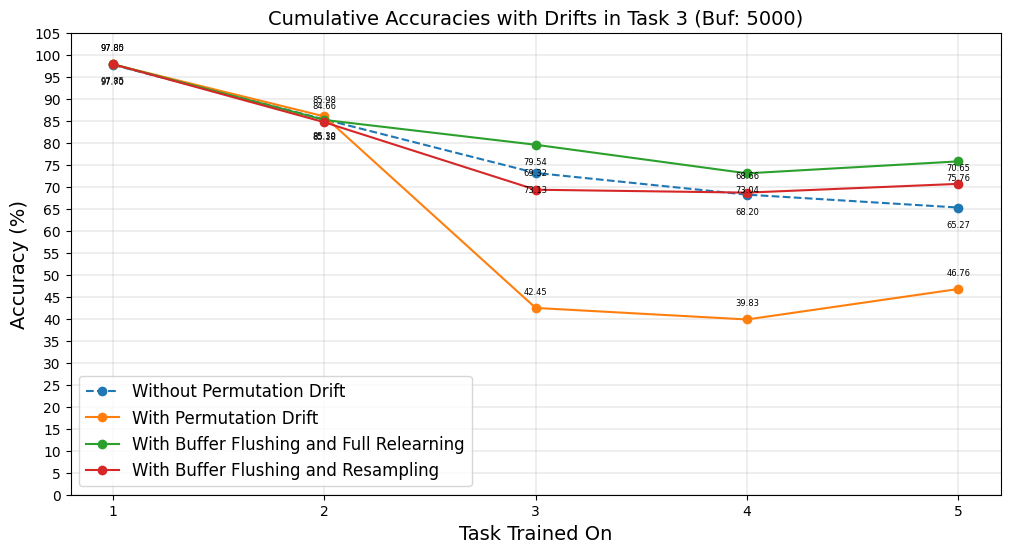

In [75]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# SER

## Buffer 500

### Accuracy Without Drift

In [76]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
# )
# ser_500_accuracy_array_without_drift = read_results(
#     "./reimplementation-logs/03-26-25-23-36-11-seq-cifar10-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
# )
# # 57.88, 58.66, 60.39
# plot_results(
#     ser_500_accuracy_array_without_drift,
#     title="SER Baseline (buf=500)",
# )

In [77]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-26-25-23-36-11-seq-cifar10-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-00-11-28-seq-cifar10-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-00-47-03-seq-cifar10-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json
FAA: 58.98 ± 1.05
Avg. Forgetting: 29.73 ± 1.04


### Permutation Drift in Task 3

In [78]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
# )
# ser_500_accuracy_array_with_drift = read_results(
#     "./reimplementation-logs/03-27-25-01-57-44-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
# )
# # 40.21, 40.33, 42.09
# plot_results(
#     ser_500_accuracy_array_with_drift,
#     title="SER with Permutation Drift in Task 3 (buf=500)",
# )

In [79]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-01-22-21-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-02-33-22-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-01-57-44-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json
FAA: 40.88 ± 0.86
Avg. Forgetting: 53.20 ± 0.75


### Permutation Drift in Task 3 with Full Relearning

In [80]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# ser_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/03-27-25-04-18-10-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 66.83, 68.01, 69.62
# plot_results(
#     ser_500_accuracy_array_with_drift_full_relearning,
#     title="SER with Permutation Drift in Task 3 and Full Relearning (buf=500)",
# )

In [81]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-05-23-19-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/03-27-25-03-24-12-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/03-27-25-04-18-10-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 68.15 ± 1.14
Avg. Forgetting: 22.05 ± 0.84


### Permutation Drift in Task 3 with Buffer Resampling

In [82]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# ser_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/03-27-25-07-17-16-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 61.44, 62.62, 63.58
# plot_results(
#     ser_500_accuracy_array_with_drift_buffer_resampling,
#     title="SER with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
# )

In [83]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-06-04-25-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/03-27-25-06-40-36-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/03-27-25-07-17-16-seq-cifar10-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 62.55 ± 0.88
Avg. Forgetting: 32.45 ± 1.48


### Cumulative Plots

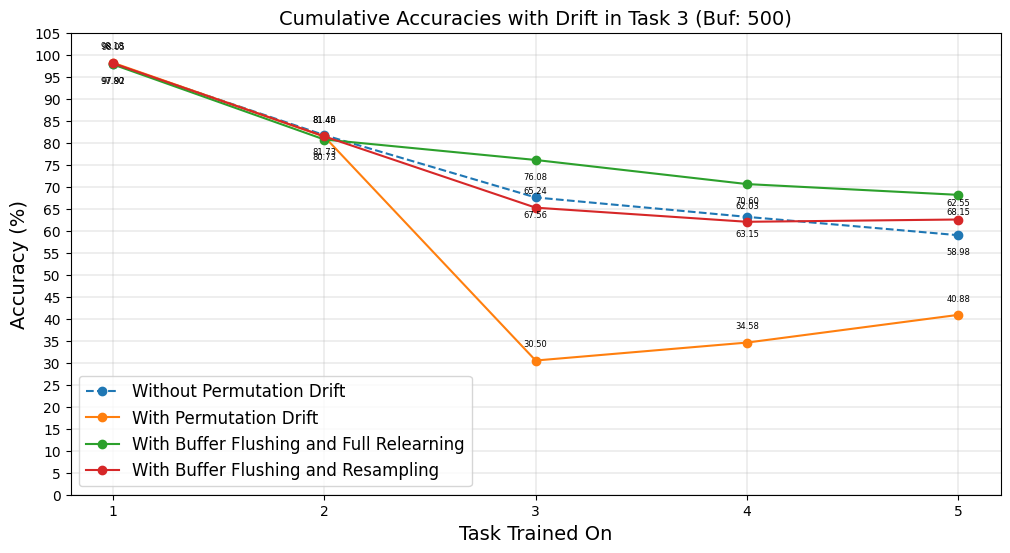

In [84]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [85]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
# )
# ser_5000_accuracy_array_without_drift = read_results(
#     "./reimplementation-logs/03-27-25-08-29-44-seq-cifar10-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
# )
# # 68.76, 69.45, 69.45
# plot_results(
#     ser_5000_accuracy_array_without_drift,
#     title="SER Baseline (buf=5000)",
# )

In [86]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-08-29-44-seq-cifar10-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-09-05-35-seq-cifar10-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-07-53-53-seq-cifar10-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
FAA: 69.22 ± 0.33
Avg. Forgetting: 15.20 ± 0.34


### Permutation Drift in Task 3

In [87]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
# )
# ser_5000_accuracy_array_with_drift = read_results(
#     "./reimplementation-logs/03-27-25-10-53-09-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
# )
# # 46.15, 46.81, 47.23
# plot_results(
#     ser_5000_accuracy_array_with_drift,
#     title="SER with Permutation Drift in Task 3 (buf=5000)",
# )

In [88]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-10-17-19-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-10-53-09-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-09-41-11-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
FAA: 46.73 ± 0.44
Avg. Forgetting: 43.97 ± 0.54


### Permutation Drift in Task 3 with Full Relearning

In [89]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# ser_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/03-27-25-11-44-39-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 71.89, 72.59, 73.73
# plot_results(
#     ser_5000_accuracy_array_with_drift_full_relearning,
#     title="SER with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
# )

In [90]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-12-37-19-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/03-27-25-13-29-37-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/03-27-25-11-44-39-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 72.74 ± 0.76
Avg. Forgetting: 12.13 ± 0.68


### Permutation Drift in Task 3 with Buffer Resampling

In [91]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# ser_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/03-27-25-14-41-16-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 72.37, 73.15, 73.37
# plot_results(
#     ser_5000_accuracy_array_with_drift_buffer_resampling,
#     title="SER with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
# )

In [92]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-14-06-08-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/03-27-25-14-41-16-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/03-27-25-15-17-23-seq-cifar10-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 72.96 ± 0.43
Avg. Forgetting: 17.36 ± 0.37


### Cumulative Plots

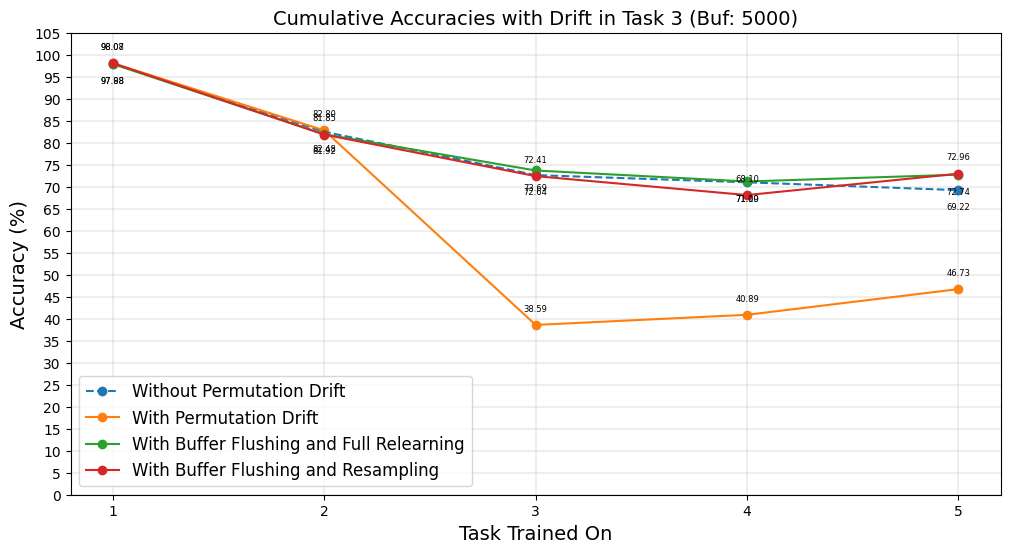

In [93]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# CLSER

## Buffer 500

### Accuracy Without Drift

In [94]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
# )
# clser_500_accuracy_array_without_drift = read_results(
#     "./reimplementation-logs/03-27-25-00-19-15-seq-cifar10-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
# )
# # 28.10, 28.66, 29.59
# plot_results(
#     clser_500_accuracy_array_without_drift,
#     title="CLSER Baseline (buf=500)",
# )

In [95]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-01-38-40-seq-cifar10-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-00-19-15-seq-cifar10-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-00-59-27-seq-cifar10-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json
FAA: 28.78 ± 0.61
Avg. Forgetting: 81.80 ± 0.90


### Permutation Drift in Task 3

In [96]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
# )
# clser_500_accuracy_array_with_drift = read_results(
#     "./reimplementation-logs/03-27-25-02-59-21-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
# )
# # 28.24, 29.38, 29.98
# plot_results(
#     clser_500_accuracy_array_with_drift,
#     title="CLSER with Permutation Drift in Task 3 (buf=500)",
# )

In [97]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-02-59-21-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-02-18-55-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-03-39-44-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json
FAA: 29.20 ± 0.72
Avg. Forgetting: 81.05 ± 1.09


### Permutation Drift in Task 3 with Full Relearning

In [98]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# clser_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/03-27-25-05-32-21-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 54.15, 54.35, 54.89
# plot_results(
#     clser_500_accuracy_array_with_drift_full_relearning,
#     title="CLSER with Permutation Drift in Task 3 and Full Relearning (buf=500)",
# )

In [99]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-05-32-21-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/03-27-25-06-40-41-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/03-27-25-04-35-48-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 54.46 ± 0.31
Avg. Forgetting: 49.34 ± 0.61


### Permutation Drift in Task 3 with Buffer Resampling

In [100]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# clser_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/03-27-25-08-24-39-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 53.13, 54.22, 54.84
# plot_results(
#     clser_500_accuracy_array_with_drift_buffer_resampling,
#     title="CLSER with Permutation Drift in Task 3 and Buffer Resampling (buf=500)",
# )

In [101]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-08-24-39-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/03-27-25-09-05-21-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/03-27-25-07-39-12-seq-cifar10-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 54.06 ± 0.71
Avg. Forgetting: 49.85 ± 1.01


### Cumulative Plots

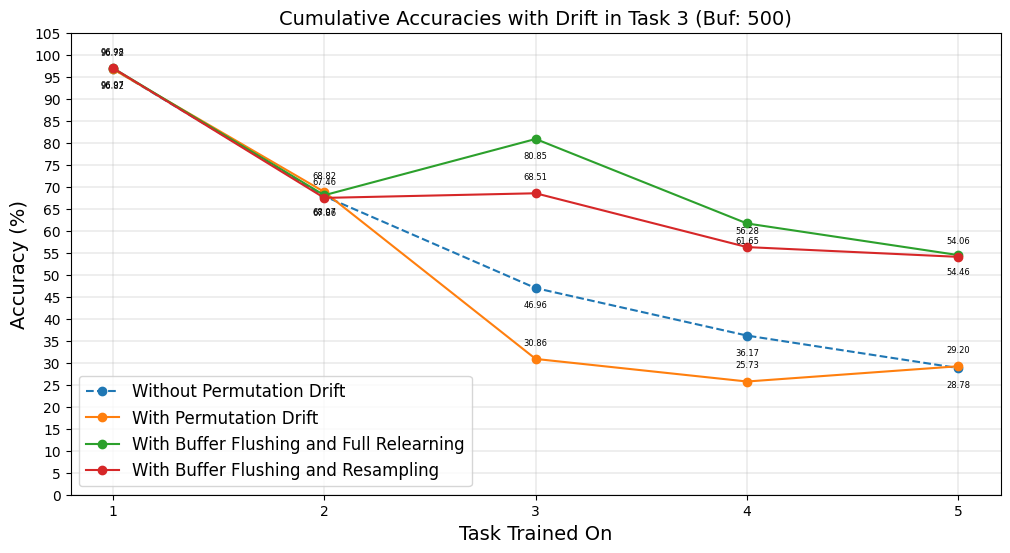

In [102]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [103]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
# )
# clser_5000_accuracy_array_without_drift = read_results(
#     "./reimplementation-logs/03-27-25-09-46-33-seq-cifar10-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
# )
# # 66.11, 66.58, 67.93
# plot_results(
#     clser_5000_accuracy_array_without_drift,
#     title="CLSER Baseline (buf=5000)",
# )

In [104]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-11-09-23-seq-cifar10-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-09-46-33-seq-cifar10-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-10-28-15-seq-cifar10-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
FAA: 66.87 ± 0.77
Avg. Forgetting: 33.13 ± 0.82


### Permutation Drift in Task 3

In [105]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
# )
# clser_5000_accuracy_array_with_drift = read_results(
#     "./reimplementation-logs/03-27-25-13-12-42-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
# )
# # 48.85, 49.08, 49.26
# plot_results(
#     clser_5000_accuracy_array_with_drift,
#     title="CLSER with Permutation Drift in Task 3 (buf=5000)",
# )

In [106]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-13-12-42-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-27-25-12-32-46-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-27-25-11-50-27-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
FAA: 49.06 ± 0.17
Avg. Forgetting: 55.47 ± 0.20


### Permutation Drift in Task 3 with Full Relearning

In [107]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# clser_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/03-27-25-15-06-31-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
# )
# # 76.11, 76.33, 76.37
# plot_results(
#     clser_5000_accuracy_array_with_drift_full_relearning,
#     title="CLSER with Permutation Drift in Task 3 and Full Relearning (buf=5000)",
# )

In [108]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-14-10-03-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/03-27-25-16-03-56-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/03-27-25-15-06-31-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 76.27 ± 0.11
Avg. Forgetting: 21.16 ± 0.18


### Permutation Drift in Task 3 with Buffer Resampling

In [109]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# clser_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/03-27-25-17-27-30-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
# )
# # 76.76, 77.07, 77.77
# plot_results(
#     clser_5000_accuracy_array_with_drift_buffer_resampling,
#     title="CLSER with Permutation Drift in Task 3 and Buffer Resampling (buf=5000)",
# )

In [110]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-17-27-30-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/03-27-25-18-08-48-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/03-27-25-16-45-46-seq-cifar10-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 77.20 ± 0.42
Avg. Forgetting: 20.18 ± 0.58


### Cumulative Plots

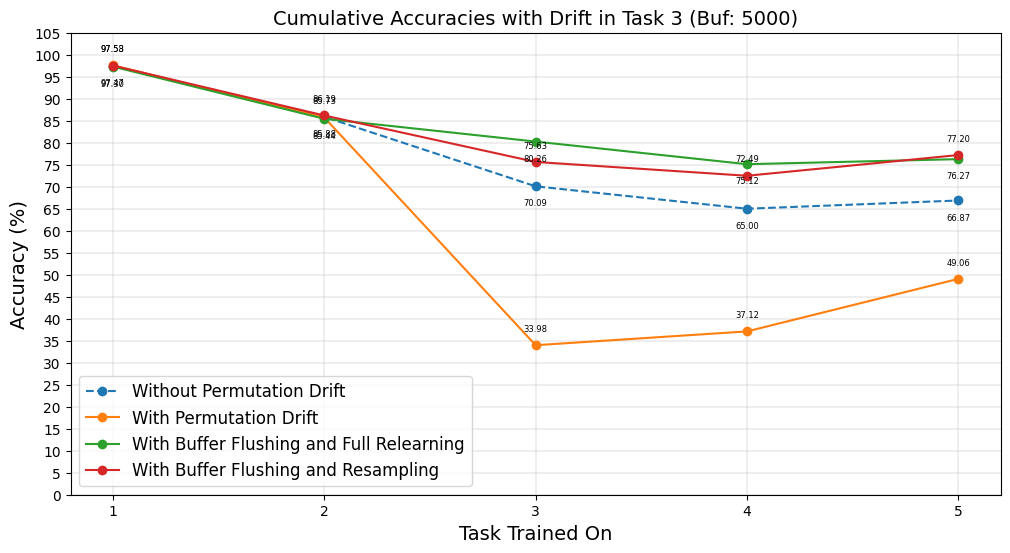

In [111]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

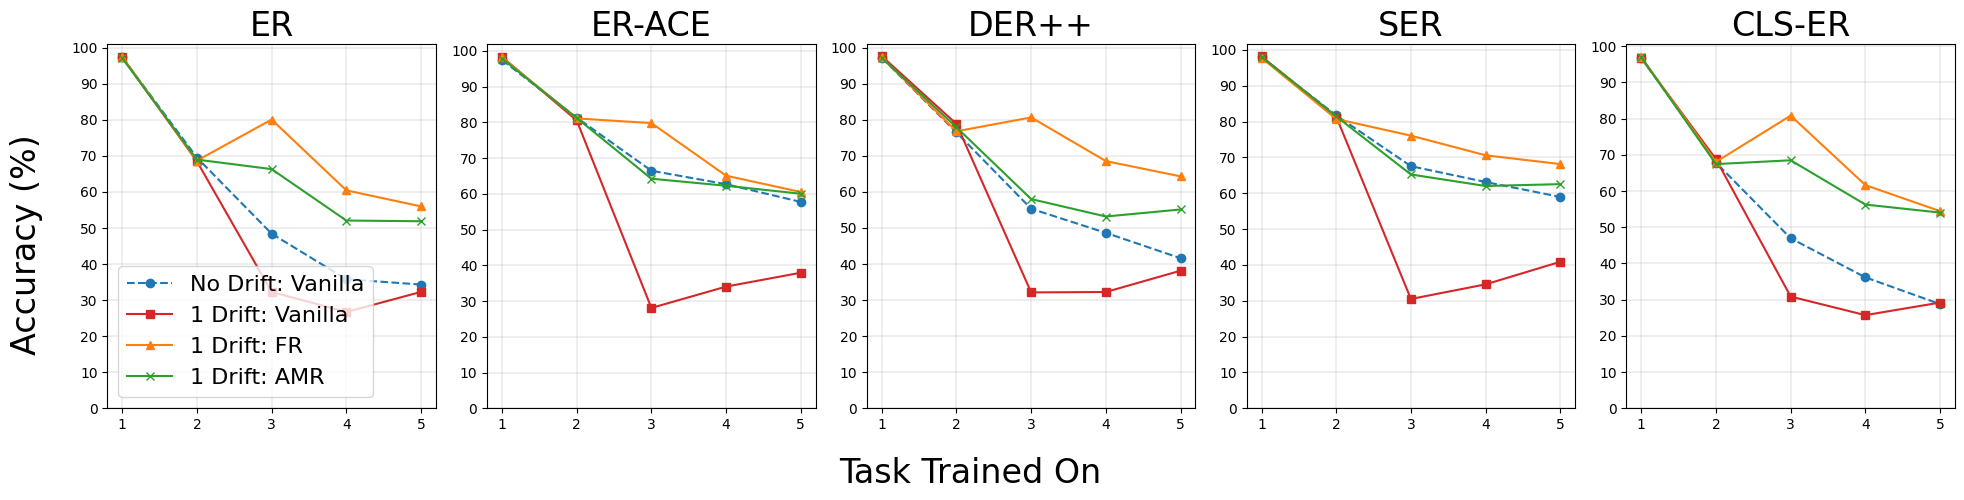

In [157]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "1 Drift: Vanilla",
        "1 Drift: FR",
        "1 Drift: AMR",
    ],
    plot_filename="CIFAR10_Buff_500_n_1.pdf",
)

## Buffer 5000

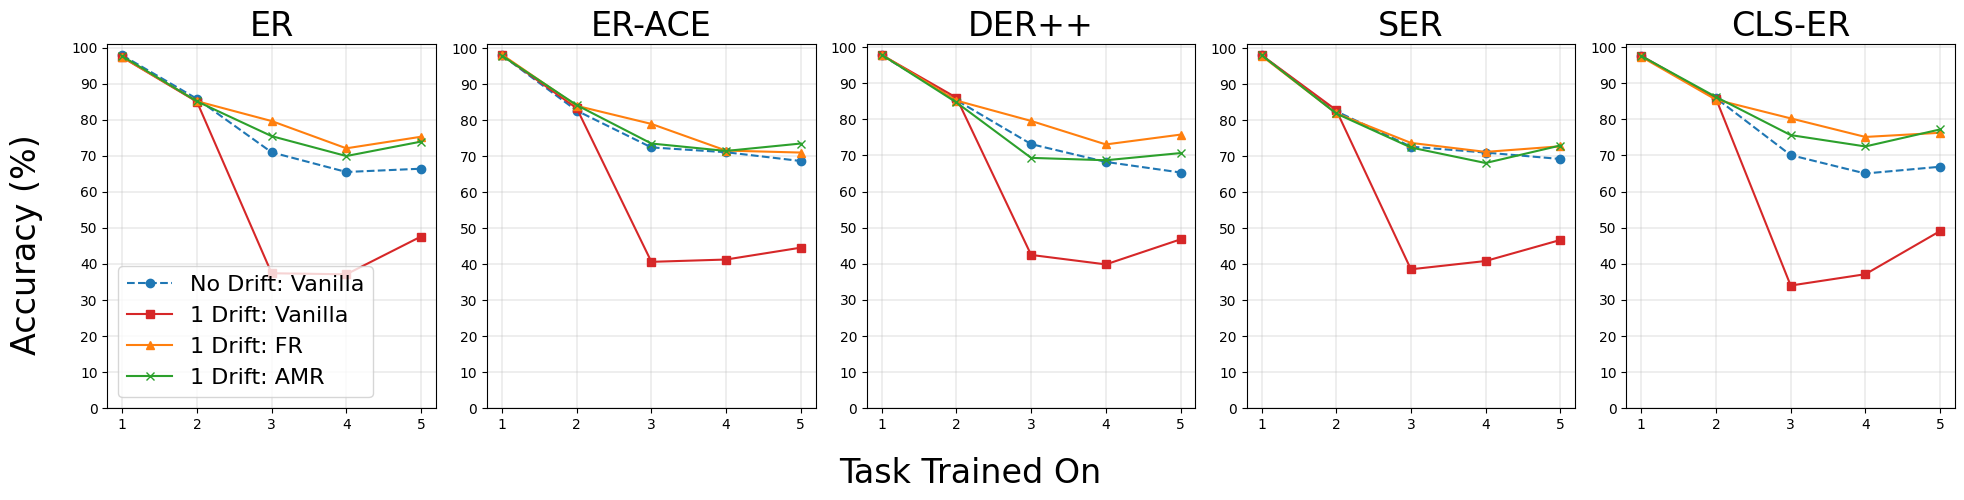

In [ ]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "1 Drift: Vanilla",
        "1 Drift: FR",
        "1 Drift: AMR",
    ],
    plot_filename="CIFAR10_Buff_5000_n_1.pdf",
)